<a id="top"></a>  
# Titanic Disaster - FE, EDA, Correlation, ML
RMS Titanic was a British passenger liner operated by the White Star Line and hailed as "unsinkable".  It sank in the Atlantic Ocean after striking an iceberg on the morning of 15 April 1912 during its maiden voyage from Southampton to New York City.  Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making the sinking of the Titanic one of the modern history's deadliest peacetime commercial marine disasters (source: en.wikipedia.org/wiki/RMS_Titanic).

---
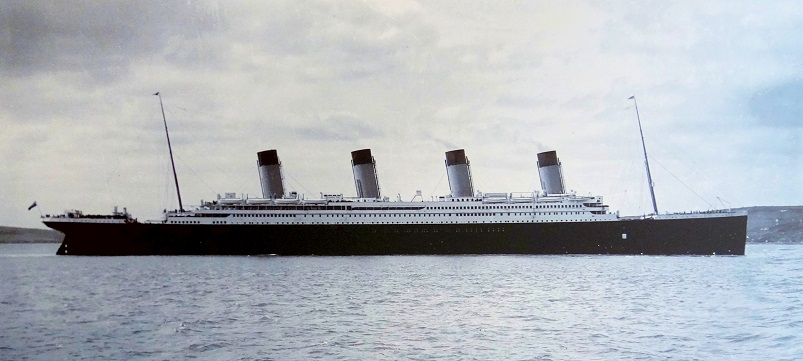

---
**Titanic: Machine Learning from Disaster** dataset contains information on 1309 passengers (891 for train & 418 for test) on the Titanic.  The challenge is to predict which of these passengers survived based on their age, sex, cabin, etc.  

This notebook will cover data cleaning, feature engineering, exploratory data analysis, mapping, feature importance, correlations, machine learning, model selection, evaluation of the model and finally, submitting the prediction file for the competition.

#### Table of Content
1. [Titanic Dataset](#titanic)   
2. [Data Cleaning](#prep)  (fill out missing information)<br>
3. [Feature Engineering #1](#engr)   (extract meaningful information and create attributes)<br>
4. [Exploratory Data Analysis](#eda)   (insights via plots)
5. [Feature Engineering #2](#engr2)   (create additional  attributes and map values)<br>
6. [Feature Importance and Correlations](#corr)   (normalization and correlations)
7. [Machine Learning](#model)  (model selection and evaluation of model)
8. [Submission File](#sub_file)  

**Import Python Libraries & Load Titanic Datasets:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 80)


#  Kaggle directories
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))


#  Load the Datasets
df_TRN = pd.read_csv('../input/train.csv')
df_TST = pd.read_csv('../input/test.csv')
print("training set:\t", df_TRN.shape, "\ntest set:\t",df_TST.shape, "\t- no \"Survived\" column")
print("\nColumns:\n",df_TRN.columns.values)

/kaggle/input/train.csv
/kaggle/input/gender_submission.csv
/kaggle/input/test.csv
gender_submission.csv
test.csv
train.csv

training set:	 (891, 12) 
test set:	 (418, 11) 	- no "Survived" column

Columns:
 ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


---
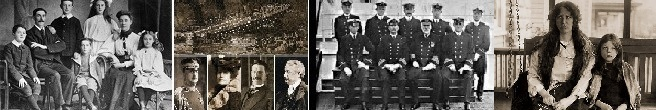


#  1.  Titanic Dataset <a id="titanic"></a>
The Titanic dataset is a subset of the actual number of 2,224 passengers on-board the Titanic.  The dataset contains the following attributes that can be identified as **Categorical**, **Numeric** and **Text** datatypes:

|**ATTRIBUTE**|**DATA TYPE**|**DESCRIPTION**|**KEY**|
|:-----|:-----|:-----|:-----|
| PassengerId 	| ``NUMERIC`` 	| Passenger ID/Ticket Number| |
| Survived 	| ``CATEGORICAL`` 	| Female Survived? 	| 0 = No, 1 = Yes |
| Pclass 	| ``CATEGORICAL``	| Ticket Class 		| 1 = 1st, 2 = 2nd, 3 = 3rd |
| Name		| ``TEXT``		| Passenger Name	| |
| Sex 		| ``CATEGORICAL``	| Male or Female 	| |
| Age		| ``NUMERIC``	| Passenger Age		| |
| SibSp		| ``CATEGORICAL``	| # of Siblings or Spouses | |
| Parch		| ``CATEGORICAL``	| # of Parents or Children | |
| Ticket	| ``TEXT``		| Ticket Number 	|  |
| Fare		| ``NUMERIC``	| Passenger Fare | |
| Cabin		| ``NUMERIC``	| Cabin Number  | |
| Embarked	| ``CATEGORICAL``	| Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

###  Statistic Summary - NUMERIC data:

In [2]:
df_TRN.describe()  # NUMERIC DATA

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


-  training dataset has 891 samples or 40% of the actual passengers
-  test dataset has 418 samples or ~19% of the actual passengers
-  survival rate of the sample population is 38%, whereas the actual survival rate was 32%
-  most of the passengers were travelling in the 3rd Class
-  most of the passengers embarked from Southampton
-  most of the passengers were under 30s years old

###  Statistic Summary - CATEGORICAL data:

In [3]:
df_TRN.describe(include='O')  # CATEGORICAL DATA

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Theobald, Mr. Thomas Leonard",male,CA. 2343,G6,S
freq,1,577,7,4,644


-  Training dataset contains 891 unique names of passengers
-  64% of the passengers were male
-  Ticket column contains alphanumeric values
-  Cabin column contains alphanumeric values
-  Most of the passengers boarded from Southampton

[go to top of document](#top)     

---

#  2.  Data Cleaning<a id="prep"></a>
Data cleaning is always required to ensure that the analysis is based on as complete a dataset as possible.  This typically involves taking care of null and duplicate values.

### Data Cleaning Sections:
[2.1  Check for NULLs/Duplicates](#prep_null)<br>
[2.2  Fill NULLs for Embarked and Fare](#prep_fare)<br>
[2.3  Fill NULLs for Age](#prep_age)<br>
[2.4  Fill NULLs for Cabin](#prep_cabin)<br>
[2.5  Final Check of NULLs/Duplicates](#prep_final)<br>

## 2.1  Check for NULLs/Duplicates <a id="prep_null"></a>
Cleaning up the NULL and duplicate values in the dataset.

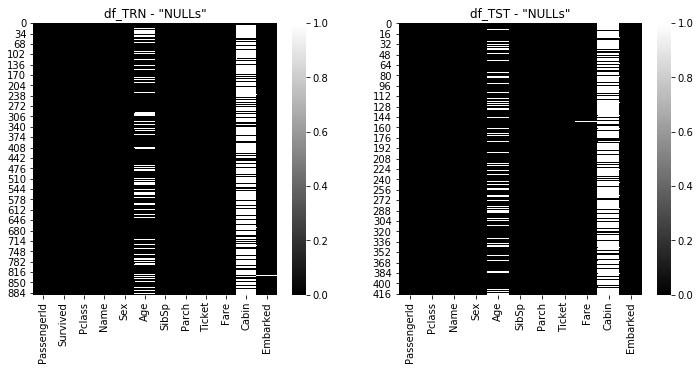

            TRAIN Data - NULL         TEST Data - NULL        
                        Total Percent            Total Percent
Age                       177   19.87             86.0   20.57
Cabin                     687   77.10            327.0   78.23
Embarked                    2    0.22              0.0    0.00
Fare                        0    0.00              1.0    0.24
Name                        0    0.00              0.0    0.00
Parch                       0    0.00              0.0    0.00
PassengerId                 0    0.00              0.0    0.00
Pclass                      0    0.00              0.0    0.00
Sex                         0    0.00              0.0    0.00
SibSp                       0    0.00              0.0    0.00
Survived                    0    0.00              NaN     NaN
Ticket                      0    0.00              0.0    0.00


Duplicated - TRAIN:  0
Duplicated - TEST:   0


In [4]:
#  heatmap of null values
fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.title('df_TRN - "NULLs\"')
sns.heatmap(df_TRN.isnull(), cmap='gray')
fig.add_subplot(122)
plt.title('df_TST - "NULLs\"')
sns.heatmap(df_TST.isnull(), cmap='gray')
plt.show()

for i in [df_TRN,df_TST]:
    nulls = i.isnull().sum().sort_values(ascending = False)
    prcet = round(nulls/len(i)*100,2)
    i.null = pd.concat([nulls, prcet], axis = 1,keys= ['Total', 'Percent'])
print(pd.concat([df_TRN.null,df_TST.null], axis=1,keys=['TRAIN Data - NULL', 'TEST Data - NULL']))

#  check for duplicate values
print('\n\nDuplicated - TRAIN:  {}'.format(df_TRN.duplicated().sum()))
print('Duplicated - TEST:   {}'.format(df_TST.duplicated().sum()))

**There are no duplicates, but four attributes have NULL values.  Following actions will be taken:**
* [Embarked](#prep_fare):  fill NULLs with most common location
* [Fare](#prep_fare):      fill NULLs with mean value
* [Age](#prep_age):       fill NULLs with mean age per Pclass per sex
* [Cabin](#prep_cabin):     fill NULLs based on Fare

[go to top of section](#prep)     

## 2.2  Fill NULLs for Embarked and Fare<a id="prep_fare"></a>
We will fill the NULLs for **Embarked** with the most common port of embarkation and the **Fare** with the mean fare.

In [5]:
#  check for null
print(df_TRN[['PassengerId','Embarked']][df_TRN['Embarked'].isnull()])
print(df_TST[['PassengerId','Fare']][df_TST['Fare'].isnull()])

df_TRN['Embarked'].fillna(df_TRN.Embarked.mode()[0], inplace=True) # fill with mode
df_TST['Fare'].fillna(df_TST['Fare'].mean(), inplace=True)      # fill with mean

#  verify nulls were filled
print(df_TRN[['PassengerId','Embarked']][df_TRN['PassengerId'].isin([62,830])])
print(df_TST[['PassengerId','Fare']][df_TST['PassengerId'] == 1044])

     PassengerId Embarked
61            62      NaN
829          830      NaN
     PassengerId  Fare
152         1044   NaN
     PassengerId Embarked
61            62        S
829          830        S
     PassengerId       Fare
152         1044  35.627188


[go to top of section](#prep)     

## 2.3  Fill NULLs for Age<a id="prep_age"></a>
We cannot fill the NULLs for age with the overall mean age because:
- first class passengers were much older than the other classes
- there is a significant difference in Pclass female passenger ages
- Mean ages for Pclass and Sex are significantly different in both datasets

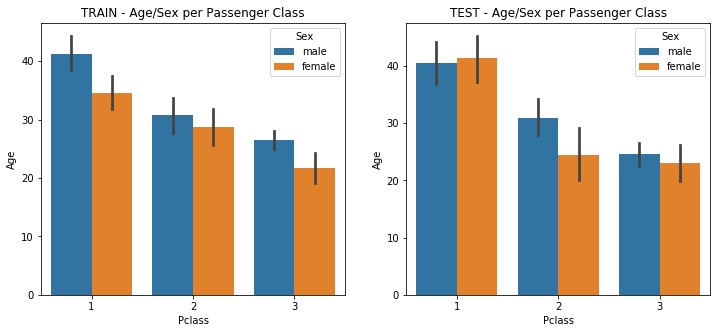

In [6]:
fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.title('TRAIN - Age/Sex per Passenger Class')
sns.barplot(data=df_TRN, x='Pclass',y='Age',hue='Sex')
fig.add_subplot(122)
plt.title('TEST - Age/Sex per Passenger Class')
sns.barplot(data=df_TST, x='Pclass',y='Age',hue='Sex')
plt.show()

We'll need to dig a little deeper and determine the mean Age per Pclass and Sex for both the datasets separately.  This will be done in two steps:

  1.  Calculate the mean Age per Pclass and Sex for both datasets
  2.  Use the values from the above table to fill out NULLs for Age

**Step 1:  Calculate Age per Pclass and Sex for training and test datasets:**

In [7]:
#  calculate age per pclass and sex
#  training - mean Age per Pclass and Sex
meanAgeTrnMale = round(df_TRN[(df_TRN['Sex'] == "male")]['Age'].groupby(df_TRN['Pclass']).mean(),2)
meanAgeTrnFeMale = round(df_TRN[(df_TRN['Sex'] == "female")]['Age'].groupby(df_TRN['Pclass']).mean(),2)

#  test - - mean Age per Pclass and Sex
meanAgeTstMale = round(df_TST[(df_TST['Sex'] == "male")]['Age'].groupby(df_TST['Pclass']).mean(),2)
meanAgeTstFeMale = round(df_TST[(df_TST['Sex'] == "female")]['Age'].groupby(df_TST['Pclass']).mean(),2)

print('\n\t\tMEAN AGE PER SEX PER PCLASS')
print(pd.concat([meanAgeTrnMale, meanAgeTrnFeMale,meanAgeTstMale, meanAgeTstFeMale], axis = 1,keys= ['TRN-Male','TRN-Female','TST-Male','TST-Female']))


		MEAN AGE PER SEX PER PCLASS
        TRN-Male  TRN-Female  TST-Male  TST-Female
Pclass                                            
1          41.28       34.61     40.52       41.33
2          30.74       28.72     30.94       24.38
3          26.51       21.75     24.53       23.07


**Step 2:  Use function *age_fillna* to fill out NULLs for Age for training and test datasets:**

In [8]:
#  define function APS to fill Age NaN for training data
def age_fillna_TRN(APStrn):
    Age     = APStrn[0]
    Pclass  = APStrn[1]
    Sex     = APStrn[2]
    
    if pd.isnull(Age):
        if Sex == 'male':
            if Pclass == 1:
                return 41.28
            if Pclass == 2:
                return 30.74
            if Pclass == 3:
                return 26.51

        if Sex == 'female':
            if Pclass == 1:
                return 34.61
            if Pclass == 2:
                return 28.72
            if Pclass == 3:
                return 21.75
    else:
        return Age

#  define function APS to fill Age NaN for test data
def age_fillna_TST(APStst):
    Age     = APStst[0]
    Pclass  = APStst[1]
    Sex     = APStst[2]
    
    if pd.isnull(Age):
        if Sex == 'male':
            if Pclass == 1:
                return 40.52
            if Pclass == 2:
                return 30.94
            if Pclass == 3:
                return 24.53

        if Sex == 'female':
            if Pclass == 1:
                return 41.33
            if Pclass == 2:
                return 24.38
            if Pclass == 3:
                return 23.07
    else:
        return Age

In [9]:
#  execute Age functions
df_TRN['Age'] = df_TRN[['Age','Pclass','Sex']].apply(age_fillna_TRN,axis=1)
df_TST['Age'] = df_TST[['Age','Pclass','Sex']].apply(age_fillna_TST,axis=1)

#  Check missing Age values
print('Missing values for Age: \ntraining\t', df_TRN.Age.isnull().sum(), "\ntest\t\t",df_TST.Age.isnull().sum())

Missing values for Age: 
training	 0 
test		 0


[go to top of section](#prep)     

## 2.4  Fill NULLs for Cabin<a id="prep_cabin"></a>
Almost 80% of **Cabin** data is missing.  This can be dropped, however, we can figure out a way to fill the missing Cabin data with a best-guess approach using the fare.

1.  fill missing Cabin data with "N"
2.  strip the letter off of Cabin, discard the numeric
3.  calculate the mean Fare per Cabin
4.  assign Cabin letter based on mean Fare per Cabin

---
**Step 1.  Fill missing Cabin data with "N"**<br>
**Step 2.  Strip the letter off of Cabin, discard the numeric**<br>
**Step 3.  Calculate the mean Fare per Cabin**

In [10]:
#  Steps 1, 2 and 3
for i in [df_TRN, df_TST]:
    i.fillna("N", inplace = True)      #  step 1
    i.Cabin = [j[0] for j in i.Cabin]  #  step 2
    i.uniq = i.Cabin.value_counts()
    i.cost = i.groupby('Cabin')['Fare'].mean()  # step 3

print('Cabin Data and mean Fare\n',pd.concat([df_TRN.uniq,df_TST.uniq,df_TRN.cost,df_TST.cost], axis=1,keys=['TRAIN Cabin', 'TEST Cabin', 'Train Fare', 'Test Fare']))

Cabin Data and mean Fare
    TRAIN Cabin  TEST Cabin  Train Fare   Test Fare
A           15         7.0   39.623887   44.716657
B           47        18.0  113.505764  145.562733
C           59        35.0  100.151341  121.033460
D           33        13.0   57.244576   42.251277
E           32         9.0   46.026694   84.921756
F           13         8.0   18.696792   17.076050
G            4         1.0   13.581250   16.700000
N          687       327.0   19.157325   19.131428
T            1         NaN   35.500000         NaN


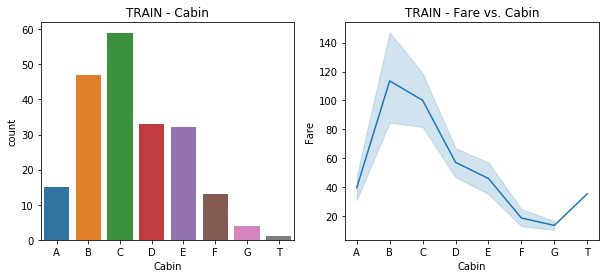

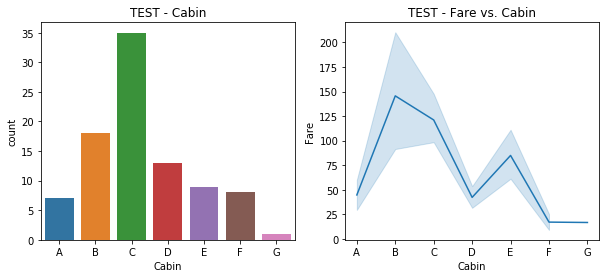

In [11]:
#  create dataframes with Cabin != N
df_TRN_noN = df_TRN[df_TRN['Cabin'] != 'N']
df_TST_noN = df_TST[df_TST['Cabin'] != 'N']

#  plot TRAIN Cabin and Fare
fig = plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.title('TRAIN - Cabin')
sns.countplot(data=df_TRN_noN, x=df_TRN_noN['Cabin'].sort_values())
fig.add_subplot(122)
plt.title('TRAIN - Fare vs. Cabin')
sns.lineplot(data=df_TRN_noN, x='Cabin', y='Fare')
plt.show()

#  plot TEST Cabin and Fare
fig = plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.title('TEST - Cabin')
sns.countplot(data=df_TST_noN, x=df_TST_noN['Cabin'].sort_values())
fig.add_subplot(122)
plt.title('TEST - Fare vs. Cabin')
sns.lineplot(data=df_TST_noN, x='Cabin', y='Fare')
plt.show()

Cabin and Fare information vary considerable between the training and test datasets.  In the next  step, we will populate all the missing Cabin values based on the average Fare for that Cabin.

**Step 4.  Use function cabin_fillN to assign Cabin letter based on mean Fare per Cabin**

In [12]:
#  Step 4 - Assign Cabin letter to all "N" based on Fare
df_TRN.groupby('Cabin')['Fare'].mean().sort_values()
def cabin_fillN_TRN(i):
    j = 0
    if i < 16:
        j = "G"
    elif i >= 16 and i <27:
        j = "F"
    elif i >= 27 and i <37:
        j = "T"
    elif i >= 37 and i <43:
        j = "A"
    elif i >= 43 and i <51:
        j = "E"
    elif i >= 51 and i <79:
        j = "D"
    elif i >= 79 and i <107:
        j = "C"
    else:
        j = "B"
    return j

df_TST.groupby('Cabin')['Fare'].mean().sort_values()
def cabin_fillN_TST(i):
    j = 0
    if i < 17:
        j = "G"
    elif i >= 17 and i <30:
        j = "F"
    elif i >= 30 and i <43:
        j = "D"
    elif i >= 43 and i <64:
        j = "A"
    elif i >= 64 and i <103:
        j = "E"
    elif i >= 103 and i <133:
        j = "C"
    else:
        j = "B"
    return j



In [13]:
#  Run function - fill out all of Cabin per mean
print("BEFORE\ntraining Cabin values:\t",df_TRN.Cabin.sort_values().unique())
print("test Cabin values:\t",df_TST.Cabin.sort_values().unique())

df_TRN.Cabin =  df_TRN.Fare.apply(cabin_fillN_TRN)
df_TST.Cabin =  df_TST.Fare.apply(cabin_fillN_TST)

print("\nAFTER\ntraining Cabin values:\t",df_TRN.Cabin.sort_values().unique())
print("test Cabin values:\t",df_TST.Cabin.sort_values().unique())

BEFORE
training Cabin values:	 ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'N' 'T']
test Cabin values:	 ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'N']

AFTER
training Cabin values:	 ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'T']
test Cabin values:	 ['A' 'B' 'C' 'D' 'E' 'F' 'G']


[go to top of section](#prep)     

## 2.5  Final Check of NULLs/Duplicates<a id="prep_final"></a>
Final check of NULLs/Duplicates before moving on to feature engineering.

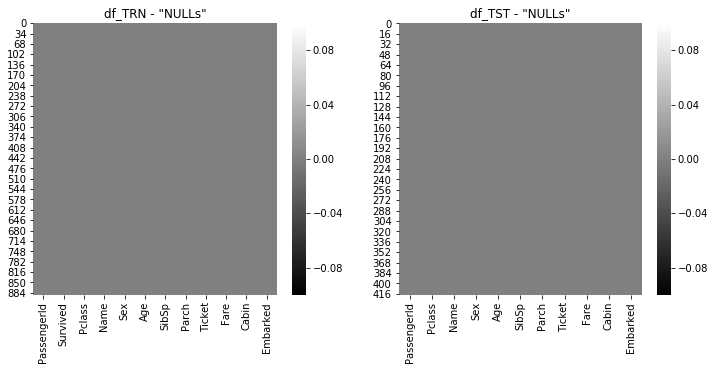

            TRAIN Data - NULL         TEST Data - NULL        
                        Total Percent            Total Percent
Age                         0     0.0              0.0     0.0
Cabin                       0     0.0              0.0     0.0
Embarked                    0     0.0              0.0     0.0
Fare                        0     0.0              0.0     0.0
Name                        0     0.0              0.0     0.0
Parch                       0     0.0              0.0     0.0
PassengerId                 0     0.0              0.0     0.0
Pclass                      0     0.0              0.0     0.0
Sex                         0     0.0              0.0     0.0
SibSp                       0     0.0              0.0     0.0
Survived                    0     0.0              NaN     NaN
Ticket                      0     0.0              0.0     0.0


Duplicated - TRAIN:  0
Duplicated - TEST:   0


In [14]:
#  heatmap of null values
fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.title('df_TRN - "NULLs\"')
sns.heatmap(df_TRN.isnull(), cmap='gray')
fig.add_subplot(122)
plt.title('df_TST - "NULLs\"')
sns.heatmap(df_TST.isnull(), cmap='gray')
plt.show()

for i in [df_TRN,df_TST]:
    nulls = i.isnull().sum().sort_values(ascending = False)
    prcet = round(nulls/len(i)*100,2)
    i.null = pd.concat([nulls, prcet], axis = 1,keys= ['Total', 'Percent'])
print(pd.concat([df_TRN.null,df_TST.null], axis=1,keys=['TRAIN Data - NULL', 'TEST Data - NULL']))

#  check for duplicate values
print('\n\nDuplicated - TRAIN:  {}'.format(df_TRN.duplicated().sum()))
print('Duplicated - TEST:   {}'.format(df_TST.duplicated().sum()))

Yay!!  All the NULLs have been taken care of!!

[go to top of document](#top)     

---
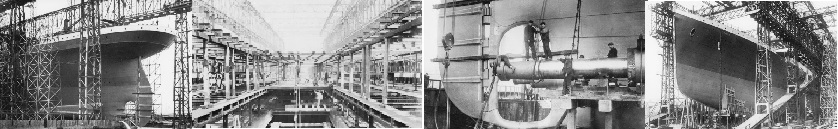

#  3. Feature Engineering #1<a id="engr"></a>
Feature engineering involves any modifications to the original dataset to facilitate machine learning algorithms.  This typically involves extracting meaningful information from attributes and/or creating new attributes.


###  Feature Engineering Section:
[3.1  Extract Cabin Information](#prep_cabin) (in previous section)<br>
[3.2  Extract Title from Name](#engr_title)<br>
[3.3  Create New Attributes - Family Size and IsAlone](#engr_familySize)<br>
[3.4  Create New Attribute - Fare per Person](#engr_farePerson)<br>


NOTE:  This section is based on *feature engineering* article in www.kaggle.com/c/titanic/data

## 3.1 Extract Cabin Information
Cabin feature engineering was completed as part of [Cabin NULL values](#prep_cabin) in the previous chapter.

[go to top of section](#engr)     

## 3.2 Extract Title from Name<a id="engr_title"></a>
Each name in the dataset contains a salutation which can be extracted.  We can use the split function to achieve this and save it in a new column called "Title".

In [15]:
df_TRN['Title'] = df_TRN['Name'].str.split(',', expand = True)[1].str.split(' ', expand = True)[1]
df_TST['Title'] = df_TST['Name'].str.split(',', expand = True)[1].str.split(' ', expand = True)[1]

#  create a list of all the titles
titles = sorted(pd.concat([df_TRN['Title'], df_TST['Title']]).unique())
print(titles)

['Capt.', 'Col.', 'Don.', 'Dona.', 'Dr.', 'Jonkheer.', 'Lady.', 'Major.', 'Master.', 'Miss.', 'Mlle.', 'Mme.', 'Mr.', 'Mrs.', 'Ms.', 'Rev.', 'Sir.', 'the']


The datasets contains the following unique Titles:

|  **Title** |  Description |  notes  |
|:-----|:-----|:-----|
| ``Capt.``|Captain | male or female  |   
| ``Col.``|Colonel  | male or female   |
| ``Don.``|male title  |    |
| ``Dona.``|female title  |    |
| ``Dr.``|doctor  | male or female   |
| ``Jonkheer.``|young lord  |    |
| ``Lady.``|lady  |    |
| ``Major.``|Major  | male or female   |
| ``Master.``|young male  |    |
| ``Miss.``|young female  |    |
| ``Mlle.``|Mademoiselle  |    |
| ``Mme.``|Madam  |    |
| ``Mr.``|adult male  |    |
| ``Mrs.``|adult female  |    |
| ``Ms.``|young female  |    |
| ``Rev.``|Reverend   | male or female   |
| ``Sir.``|adult male  |    |
| ``the``|  unknown  | male or female   |

Following Titles will have to confirmed as male or female, and replaced with either "Mr." or "Mrs."

-  Capt., Col., Dr., Major., Rev., the

In [16]:
#  Check Titles that may be male or female
for i in [df_TRN,df_TST]:
    print(i[['PassengerId','Title','Sex']][i['Title'].isin(['Capt.', 'Col.', 'Dr.', 'Major.', 'Rev.', 'the'])],"\n")
    
#  
print(df_TRN[['PassengerId','Title','Sex']][df_TRN['PassengerId'].isin([760,797])])

     PassengerId   Title     Sex
149          150    Rev.    male
150          151    Rev.    male
245          246     Dr.    male
249          250    Rev.    male
317          318     Dr.    male
398          399     Dr.    male
449          450  Major.    male
536          537  Major.    male
626          627    Rev.    male
632          633     Dr.    male
647          648    Col.    male
660          661     Dr.    male
694          695    Col.    male
745          746   Capt.    male
759          760     the  female
766          767     Dr.    male
796          797     Dr.  female
848          849    Rev.    male
886          887    Rev.    male 

     PassengerId Title   Sex
131         1023  Col.  male
149         1041  Rev.  male
164         1056  Rev.  male
202         1094  Col.  male
293         1185   Dr.  male 

     PassengerId Title     Sex
759          760   the  female
796          797   Dr.  female


We can see that all except PassengerIDs 760 and 797 in training are female.

Create function **replace_titles** to update the titles, verifying **Sex** of some of the titles before replacement.

In [17]:
def replace_titles(x):
    title=x['Title']
    if title in ['Don.', 'Sir.']:
        return 'Mr.'       # adult male
    elif title in ['Jonkheer.', 'Master.']:
        return 'Master.'    # young male
    elif title in ['Dona.', 'Lady.', 'Mme.']:
        return 'Mrs.'      # adult female
    elif title in ['Mlle.', 'Ms.']:
        return 'Miss.'     #  young female
    elif title in ['Capt.', 'Col.', 'Dr.', 'Major.', 'Rev.', 'the']:
        if x['Sex']=='Male':
            return 'Mr.'
        else:
            return 'Mrs.'
    else:
        return title

#  Run the function
df_TRN['Title']=df_TRN.apply(replace_titles, axis=1)
df_TST['Title']=df_TST.apply(replace_titles, axis=1)

print('df_TRN Titles:\t',df_TRN.Title.unique())
print('df_TST Titles:\t',df_TST.Title.unique())

df_TRN Titles:	 ['Mr.' 'Mrs.' 'Miss.' 'Master.']
df_TST Titles:	 ['Mr.' 'Mrs.' 'Miss.' 'Master.']


Verifying that PassengerIDs 760 and 797 titles were correctly updated to "Mrs."

In [18]:
#  Re-Check Titles that may be male or female
print(df_TRN[['PassengerId','Title','Sex']][df_TRN['PassengerId'].isin([760,797])])

     PassengerId Title     Sex
759          760  Mrs.  female
796          797  Mrs.  female


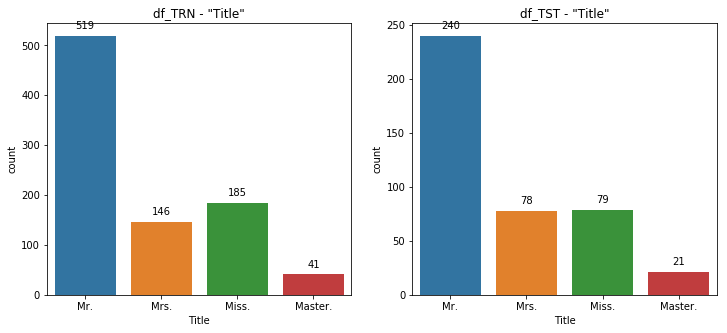

In [19]:
fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.title('df_TRN - "Title\"')
ax = sns.countplot(data = df_TRN, x = 'Title')
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(),(p.get_x()+p.get_width()/2.,p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
fig.add_subplot(122)
plt.title('df_TST - "Title\"')
ax = sns.countplot(data = df_TST, x = 'Title')
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(),(p.get_x()+p.get_width()/2.,p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

[go to top of section](#engr)     

## 3.3 Create New Attributes - FamilySize and IsAlone<a id="engr_familySize"></a>
**SibSp** and **Parch** can be combined into a new attribute **FamilySize** to give a better overview of the passengers with families.  New attribute **IsAlone** will show whether a passenger was travelling alone or with family.

In [20]:
for i in [df_TRN,df_TST]:
    i['FamilySize'] = i['SibSp'] + i['Parch'] + 1
    #  IsAlone - create attribute
    i['IsAlone']  = 0    # set default to '0'
    i.loc[i['FamilySize'] == 1, 'IsAlone'] = 1

#  check
print(sorted(df_TRN.FamilySize.unique()))
print(sorted(df_TST.FamilySize.unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 11]
[1, 2, 3, 4, 5, 6, 7, 8, 11]


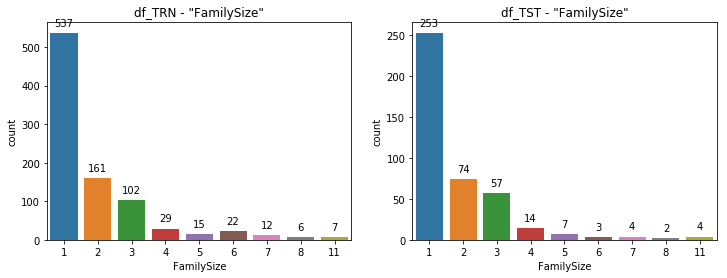

In [21]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plt.title('df_TRN - "FamilySize\"')
ax = sns.countplot(data = df_TRN, x = 'FamilySize')
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(),(p.get_x()+p.get_width()/2.,p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
fig.add_subplot(122)
plt.title('df_TST - "FamilySize\"')
ax = sns.countplot(data = df_TST, x = 'FamilySize')
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(),(p.get_x()+p.get_width()/2.,p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

[go to top of section](#engr)     

## 3.4 Create New Attribute - FarePerPerson<a id="engr_farePerson"></a>

**FarePerPerson**  will give the average fare based on the size of the family.


In [22]:
df_TRN['FarePerPerson'] = df_TRN['Fare']/(df_TRN['FamilySize'])
df_TST['FarePerPerson'] = df_TST['Fare']/(df_TST['FamilySize'])

print(df_TRN[['Fare','FamilySize','FarePerPerson']].groupby(['FamilySize']).mean())

                 Fare  FarePerPerson
FamilySize                          
1           21.242689      21.242689
2           49.894129      24.947064
3           39.692482      13.230827
4           54.864510      13.716128
5           58.094453      11.618891
6           73.722727      12.287121
7           29.366667       4.195238
8           46.900000       5.862500
11          69.550000       6.322727


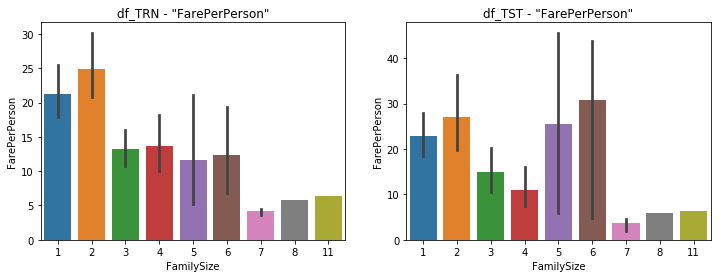

In [23]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plt.title('df_TRN - "FarePerPerson\"')
sns.barplot(x='FamilySize',y='FarePerPerson', data=df_TRN)
fig.add_subplot(122)
plt.title('df_TST - "FarePerPerson\"')
sns.barplot(x='FamilySize',y='FarePerPerson', data=df_TST)
plt.show()

[go to top of section](#engr)     

## 3.5 Create New Attribute - AgeGroup<a id="engr_farePerson"></a>
 **AgeGroup** is based on the ages of the passenger and will be useful for visualizations.  It will be dropped for correlation and modeling.

|  Age Group | age ranges (years) |
|:----|:----|
|Infant     | < 1|
|Child      | >= 1 and < 13|
|Teenager   | >= 13 and < 19|
|Young Adult| >= 19 and < 35|
|Adult      | >= 35 and < 65|
|Elderly    | >= 65|

In [24]:
def ageGroup(i):
    j = 0
    if i < 1:
        j = "Infant"
    elif i >= 1 and i <13:
        j = "Child"
    elif i >= 13 and i <19:
        j = "Teenager"
    elif i >= 19 and i <35:
        j = "Young Adult"
    elif i >= 35 and i <65:
        j = "Adult"
    else:
        j = "Elderly"
    return j

df_TRN['AgeGroup']=df_TRN.Age.apply(ageGroup)
df_TST['AgeGroup']=df_TST.Age.apply(ageGroup)

print(df_TRN.AgeGroup.unique())

['Young Adult' 'Adult' 'Child' 'Teenager' 'Elderly' 'Infant']


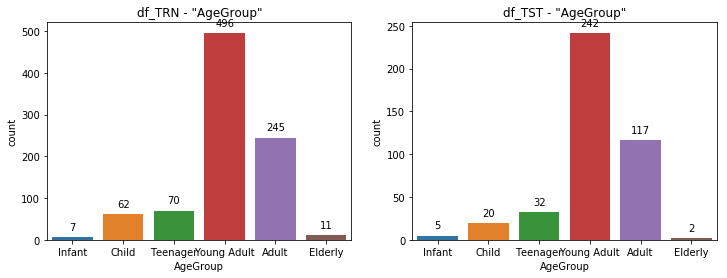

In [25]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plt.title('df_TRN - "AgeGroup\"')
ax = sns.countplot(data = df_TRN, x = 'AgeGroup',order=['Infant','Child','Teenager','Young Adult','Adult','Elderly'])
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(),(p.get_x()+p.get_width()/2.,p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
fig.add_subplot(122)
plt.title('df_TST - "AgeGroup\"')
ax = sns.countplot(data = df_TST, x = 'AgeGroup',order=['Infant','Child','Teenager','Young Adult','Adult','Elderly'])
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(),(p.get_x()+p.get_width()/2.,p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

[go to top of document](#top)     

---
<a id="eda"></a>
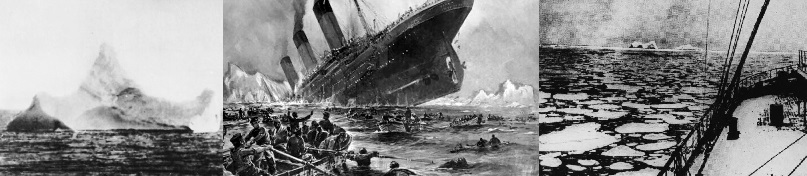

#  4. Exploratory Data Analysis
Now that the data has been cleaned and engineered, we can start visualizing the data and see if we can gain some insight into the survival rates.

### Exploratory Data Analysis Section:
[4.1  Plot - Overall Survival](#eda_over)<br>
[4.2  Plot - Sex and Title](#eda_sexTitle)<br>
[4.3  Plot - Pclass, Cabin and Embarked](#eda_PclassEmb)<br>
[4.4  Plot - SibSp, Parch and FamilySize](#eda_SibParFam)<br>
[4.5  Plot - Age and AgeGroup](#eda_Age)<br>
[4.6  Plot - Fare and FarePerPerson](#eda_Fare)<br>
[4.7  Plot - Age and Fare distribution per PClass](#eda_AgePclass)<br>


###  Function for Survival Rate:
The plots will give a good visual representation of the survival rates.  However, we'd like to see the actual numeric survival rates also.  Function **survival_rate** is created to accomplish this and will used throughout the analysis.

In [26]:
#  Funtion survival_rate
#  input:  attributes
#  output:  printsurvival rates for all unique values in the attribute
def survival_rate(*args):
    for i in args:
        print("{:12}   ---------------------------------".format(i.upper()))
        x = sorted(df_TRN[i].unique())  # values in attribute
        for j in x:
            y = len(df_TRN[i][(df_TRN[i] == j) & (df_TRN['Survived'] == 1)])  # survived number
            z = len(df_TRN[i][df_TRN[i] == j])   # total number
            print('   {:<12}{:3} out of {:3} survived -  {:3.2%}'.format(j,y,z,y/z))
    return
print("\tfunction \'survival_rate\' created.")

	function 'survival_rate' created.


## 4.1  Plot - Overall Survival<a id="eda_over"></a>
We'll start with looking at the overall survival rate of Titanic passengers before digging deeper into other attributes.

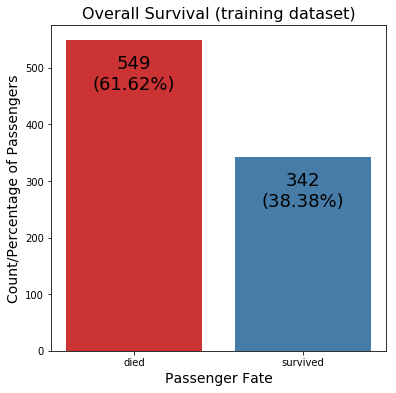

In [27]:
fig = plt.figure(figsize=(6,6))
sns.countplot(x='Survived',data=df_TRN, palette='Set1')
plt.title('Overall Survival (training dataset)',fontsize= 16)
plt.xlabel('Passenger Fate',fontsize = 14)
plt.ylabel('Count/Percentage of Passengers',fontsize = 14)
plt.axis('auto')
plt.xticks(np.arange(2), ['died', 'survived'])
labels = df_TRN['Survived'].value_counts()
for x, y in enumerate(labels):
    z = "{}\n({:.2%})".format(y,y/len(df_TRN))
    plt.text(x, y-60, str(z), ha = 'center', va='center', size = 18)
plt.show()

**OBSERVATIONS:**

*  **Overall**:  Chances of surviving the sinking were around 40%.  This may sound good (or ok, at least) till we start looking into other factors such as sex, age, family sizes, fare, etc. in the next sections.

[go to top of section](#eda)

## 4.2  Plot - Sex and Title<a id="eda_sexTitle"></a>
Plots for **Sex** will show that it's a major factor in the survival of the sinking.  **Title** will further breakdown **Sex** into young (master & miss) and old (mr and mrs) passengers.

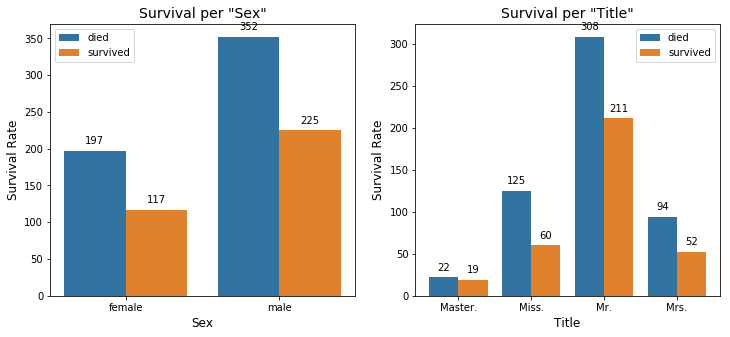

SEX            ---------------------------------
   female      233 out of 314 survived -  74.20%
   male        109 out of 577 survived -  18.89%
TITLE          ---------------------------------
   Master.      23 out of  41 survived -  56.10%
   Miss.       130 out of 185 survived -  70.27%
   Mr.          82 out of 519 survived -  15.80%
   Mrs.        107 out of 146 survived -  73.29%


In [28]:
plotList = ['Sex', 'Title']

fig = plt.figure(figsize=(12,5))
plotNum  = 1     # initialize plot number
for i in plotList:
    fig.add_subplot(1,2,plotNum)
    ax = sns.countplot(x=sorted(df_TRN[i]),hue='Survived',data=df_TRN)
    plt.title('Survival per \"{}\"'.format(i), fontsize=14)
    plt.xlabel(i, fontsize=12)
    plt.ylabel('Survival Rate', fontsize=12)
    plt.axis('auto')
    plt.legend(('died', 'survived'), loc='best')
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_height(),(p.get_x()+p.get_width()/2.,p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plotNum = plotNum + 1
plt.show()

#  Survival Rate
for i in plotList:
    survival_rate(i)

**OBSERVATIONS:**

*  **Sex**:  There were more male passengers on the Titanic, however, they also constituted a significant portion (over 81.11%) of the fatalities when the ship sank.  Females had a much higher (almost 75%) likelihood of surviving the disaster.
*  **Title**:  Young males had a 56% likelihood of surviving, whereas, adult males were very likely to die.  Females, young and adult had an over 70% of surviving the sinking.

[go to top of section](#eda)

## 4.3  Plot - Pclass, Cabin and Embarked<a id="eda_PclassEmb"></a>
Passenger class, cabin location and port of embarkation played significant roles in the survival rate of the passengers.

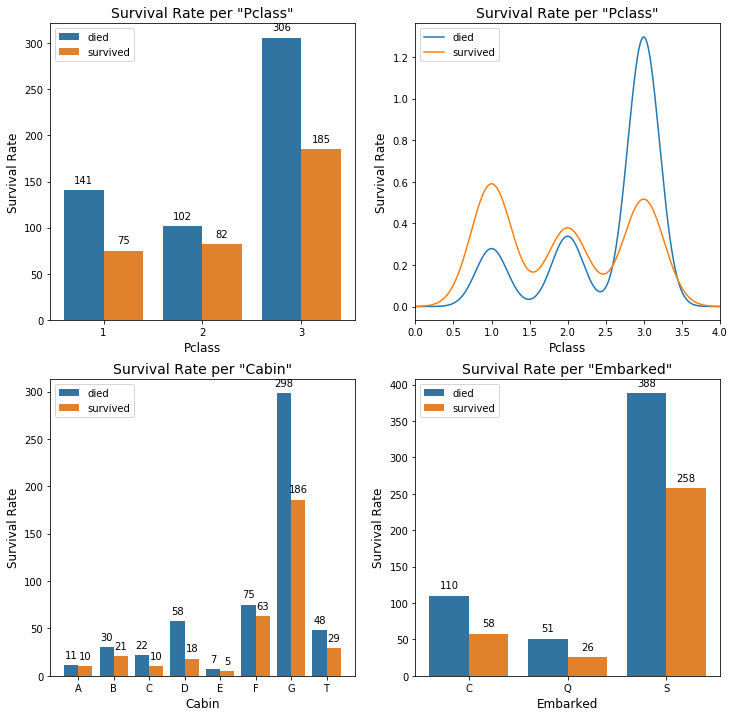

PCLASS         ---------------------------------
   1           136 out of 216 survived -  62.96%
   2            87 out of 184 survived -  47.28%
   3           119 out of 491 survived -  24.24%
CABIN          ---------------------------------
   A             8 out of  21 survived -  38.10%
   B            38 out of  51 survived -  74.51%
   C            25 out of  32 survived -  78.12%
   D            46 out of  76 survived -  60.53%
   E             2 out of  12 survived -  16.67%
   F            67 out of 138 survived -  48.55%
   G           127 out of 484 survived -  26.24%
   T            29 out of  77 survived -  37.66%
EMBARKED       ---------------------------------
   C            93 out of 168 survived -  55.36%
   Q            30 out of  77 survived -  38.96%
   S           219 out of 646 survived -  33.90%


In [29]:
plotList = ['Pclass','Cabin','Embarked']

fig = plt.figure(figsize=(12,12))
plotNum  = 1     # initialize plot number
for i in plotList:
    fig.add_subplot(2,2,plotNum)
    ax = sns.countplot(x=sorted(df_TRN[i]),hue='Survived',data=df_TRN)
    plt.title('Survival Rate per \"{}\"'.format(i), fontsize=14)
    plt.xlabel(i, fontsize=12)
    plt.ylabel('Survival Rate', fontsize=12)
    plt.axis('auto')
    plt.legend(('died', 'survived'), loc='best')
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_height(),(p.get_x()+p.get_width()/2.,p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plotNum = plotNum + 1
    if i == 'Pclass':  #  add kde plot for Pclass (numeric)
        fig.add_subplot(2,2,plotNum)
        df_TRN.Pclass[df_TRN.Survived == 0].plot(kind='kde')
        df_TRN.Pclass[df_TRN.Survived == 1].plot(kind='kde')
        plt.title('Survival Rate per \"{}\"'.format(i), fontsize=14)
        plt.xlabel(i, fontsize=12)
        plt.ylabel('Survival Rate', fontsize=12)
        plt.legend(('died', 'survived'), loc='best')
        plt.xlim(0,4)
        plotNum = plotNum + 1
plt.show()

#  Survival Rate
for i in plotList:
    survival_rate(i)

**OBSERVATIONS:**


*  **Pclass**:  Passengers in 1st class had the best chance of surviving (62.96%), whereas the 3rd class passenger had the highest chance of not surviving.
*  **Cabin**:  Passengers in B, C and D classes had the best chances of surviving, whereas, passengers in E and G classes had the lowest chance of survival.
*  **Embarked**:  Most of the first-class passengers boarded from Cherbourg, France, and were more likely to survive the disaster.  Third class passengers primarily boarded from Southampton and were less likely to survive.

[go to top of section](#eda)

## 4.4  Plot - SibSp, Parch and FamilySize<a id="eda_SibParFam"></a>
Passengers will family members.<br><br>
SibSp 	    - number of Siblings or Spouses<br>
Parch 	    - number of Parents or Children<br>
FamilySize  - total number of family members

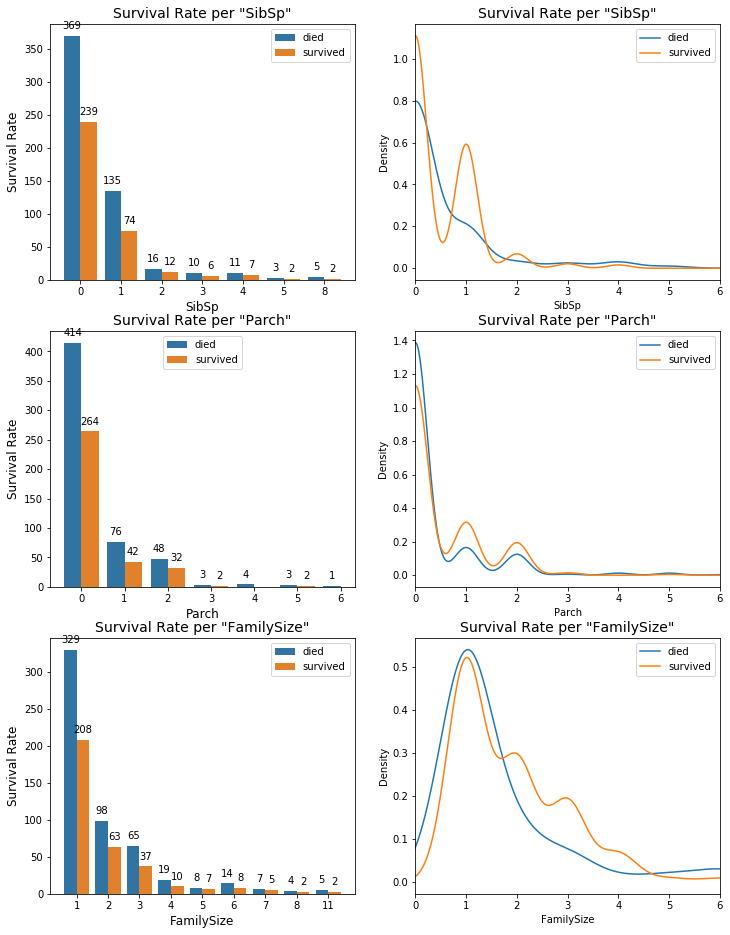

SIBSP          ---------------------------------
   0           210 out of 608 survived -  34.54%
   1           112 out of 209 survived -  53.59%
   2            13 out of  28 survived -  46.43%
   3             4 out of  16 survived -  25.00%
   4             3 out of  18 survived -  16.67%
   5             0 out of   5 survived -  0.00%
   8             0 out of   7 survived -  0.00%
PARCH          ---------------------------------
   0           233 out of 678 survived -  34.37%
   1            65 out of 118 survived -  55.08%
   2            40 out of  80 survived -  50.00%
   3             3 out of   5 survived -  60.00%
   4             0 out of   4 survived -  0.00%
   5             1 out of   5 survived -  20.00%
   6             0 out of   1 survived -  0.00%
FAMILYSIZE     ---------------------------------
   1           163 out of 537 survived -  30.35%
   2            89 out of 161 survived -  55.28%
   3            59 out of 102 survived -  57.84%
   4            21 out o

In [30]:
plotList = ['SibSp', 'Parch', 'FamilySize']

fig = plt.figure(figsize=(12,16))
plotNum  = 1     # initialize plot number
for i in plotList:
    fig.add_subplot(3,2,plotNum)
    ax = sns.countplot(x=sorted(df_TRN[i]),hue='Survived',data=df_TRN)
    plt.title('Survival Rate per \"{}\"'.format(i), fontsize=14)
    plt.xlabel(i, fontsize=12)
    plt.ylabel('Survival Rate', fontsize=12)
    plt.axis('auto')
    plt.legend(('died', 'survived'), loc='best')
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_height(),(p.get_x()+p.get_width()/2.,p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plotNum = plotNum + 1
    fig.add_subplot(3,2,plotNum)
    df_TRN[i][df_TRN.Survived == 0].plot(kind='kde')
    df_TRN[i][df_TRN.Survived == 1].plot(kind='kde')
    plt.title('Survival Rate per \"{}\"'.format(i), fontsize=14)
    plt.xlabel(i)
    plt.legend(('died', 'survived'), loc='best')
    plt.xlim(0,6)
    plotNum = plotNum + 1
plt.show()

#  Survival Rate
for i in plotList:
    survival_rate(i)

**OBSERVATIONS:**

*  **SibSp**:  Passengers with 1 or 2 siblings or spouse were more like to survive the sinking, but passenger survival rates decreased dramatically if there were more than 3 family members.
*  **Parch**:  Passengers with children were more likely to survive, however, if there were more than four family members, the survival rate went down significantly.  This could be due larger families wanting to stay together on the ship and hope for a rescue.
*  **FamilySize**:  Families with three of less members had a better chance of surviving.  Again, family size greater that four significantly impacted the chances of survival.  Passengers that were by themselves were more likely to die.

[go to top of section](#eda)

## 4.5  Plot - Age and AgeGroup<a id="eda_Age"></a>
**Age Group** will show the age ranges of the passengers that survived or died and is defined as:

|  Age Group | age ranges (years) |
|:----|:----|
|Infant     | < 1|
|Child      | >= 1 and < 13|
|Teenager   | >= 13 and < 19|
|Young Adult| >= 19 and < 35|
|Adult      | >= 35 and < 65|
|Elderly    | >= 65|

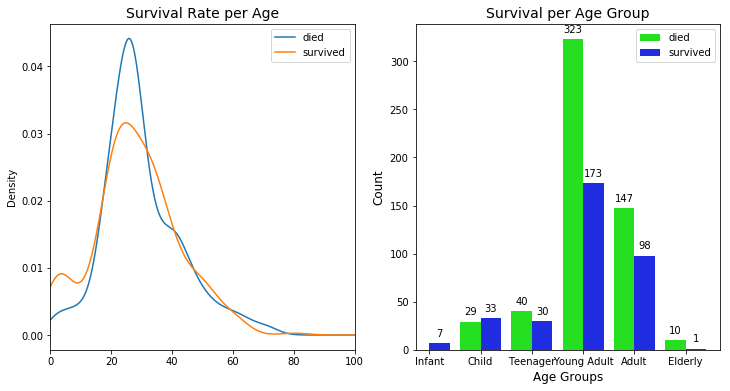

AGEGROUP       ---------------------------------
   Adult        98 out of 245 survived -  40.00%
   Child        33 out of  62 survived -  53.23%
   Elderly       1 out of  11 survived -  9.09%
   Infant        7 out of   7 survived -  100.00%
   Teenager     30 out of  70 survived -  42.86%
   Young Adult 173 out of 496 survived -  34.88%

mean age: 29.32.
mode age: 26.51.


In [31]:
fig = plt.figure(figsize=(12,6))
#  Survival per Age
fig.add_subplot(121)
df_TRN.Age[df_TRN.Survived == 0].plot(kind='kde')
df_TRN.Age[df_TRN.Survived == 1].plot(kind='kde')
plt.title('Survival Rate per Age', fontsize=14)
plt.legend(('died', 'survived'), loc='best')
plt.xlim(0,100)

fig.add_subplot(122)
#  Survival per AgeGroup
ax = sns.countplot(x='AgeGroup',data=df_TRN,hue='Survived',order=['Infant','Child','Teenager','Young Adult','Adult','Elderly'], palette='hsv')
plt.title('Survival per Age Group',fontsize= 14)
plt.xlabel('Age Groups',fontsize = 12)
plt.ylabel('Count',fontsize = 12)
plt.legend(['died', 'survived'])
plt.axis('auto')
for p in ax.patches:
   ax.annotate("%.0f" % p.get_height(),(p.get_x()+p.get_width()/2.,p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

survival_rate('AgeGroup')
print('\nmean age: {:.2f}.'.format(df_TRN.Age.mean()))
print('mode age: {:.2f}.'.format(df_TRN.Age.mode()[0]))

**OBSERVATIONS:**

*  **Age**:  Most of the passengers were around 30 years old and they were most likely to die.  As we've seen on the Sex plots, majority of the 30 year old surviving were adult females, hence the chances of an adult male surviving were very low.
*  **AgeGroup**:  Elderlies were most likely to die while infants were most likely to survive.  Young Adults, which made up most of the passengers, barely had a 35% change of surviving.

[go to top of section](#eda)

## 4.6  Plot - Fare and FarePerPerson<a id="eda_Fare"></a>
Plots look at the distribution of Fare and FarePerPerson.

max fare: $512.33.


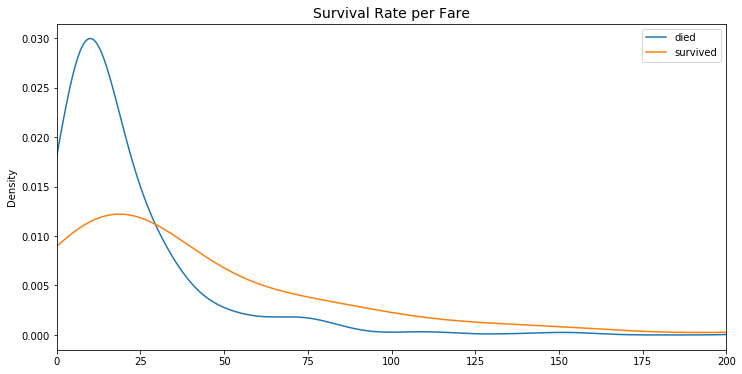

In [32]:
#  Plot - Survival/Death for Fare
plt.figure(figsize=(12,6))
df_TRN.Fare[df_TRN.Survived == 0].plot(kind='kde')
df_TRN.Fare[df_TRN.Survived == 1].plot(kind='kde')
plt.title('Survival Rate per Fare', fontsize=14)
plt.legend(('died', 'survived'), loc='best')
plt.xlim(0,200)

print('max fare: ${:.2f}.'.format(df_TRN.Fare.max()))

###  Distribution Plots for FarePerPerson 

(0, 120)

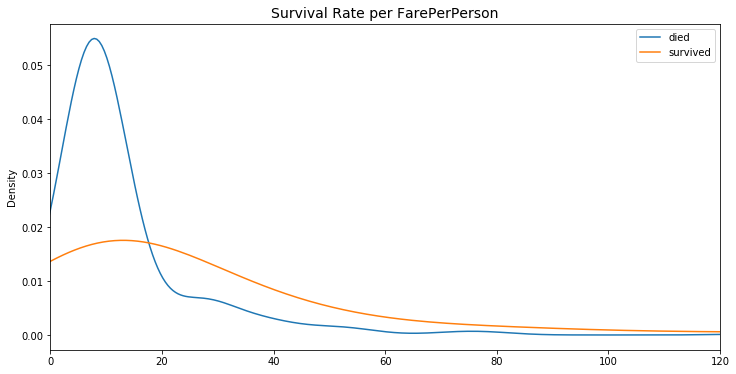

In [33]:
#  Plot - Survival/Death for FarePerPerson
plt.figure(figsize=(12,6))
df_TRN.FarePerPerson[df_TRN.Survived == 0].plot(kind='kde')
df_TRN.FarePerPerson[df_TRN.Survived == 1].plot(kind='kde')
plt.title('Survival Rate per FarePerPerson', fontsize=14)
plt.legend(('died', 'survived'), loc='best')
plt.xlim(0,120)

**OBSERVATIONS:**
*  **Fare**:  Passengers paying the lower fares were most likely to die.  That is primarily due to the fact that most of the passengers on the Titanic were travelling in the 2nd or 3rd class.
*  **FarePerPerson**:  Again, we see that younger people paying the lower fares were most like to die.

[go to top of section](#eda)

## 4.7  Plot - Age and Fare distribution per Pclass<a id="eda_AgePclass"></a>
Plots look at the distribution of Age and Fare based on the passenger class (Pclass).

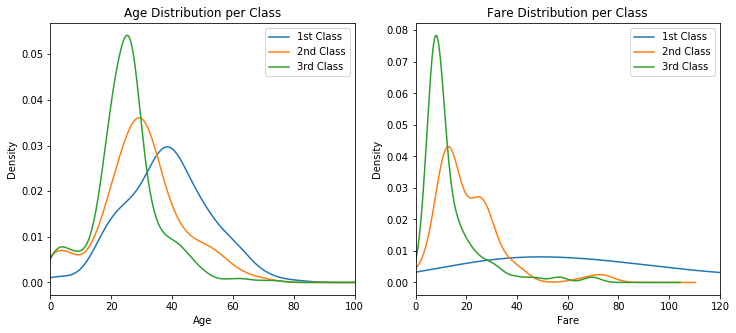

,1st-Age,2nd-Age,3rd-Age,1st-Fare,2nd-Fare,3rd-Fare
count,216.000000,184.000000,491.000000,216.000000,184.000000,491.000000
mean,38.378657,29.907228,25.112749,84.154687,20.662183,13.675550
std,13.783469,13.575613,10.683815,78.380373,13.417399,11.778142
min,0.920000,0.670000,0.420000,0.000000,0.000000,0.000000
25%,29.000000,23.000000,20.250000,30.923950,13.000000,7.750000
50%,38.000000,30.000000,26.000000,60.287500,14.250000,8.050000
75%,47.250000,36.000000,29.000000,93.500000,26.000000,15.500000
max,80.000000,70.000000,74.000000,512.329200,73.500000,69.550000


In [34]:
fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
df_TRN.Age[df_TRN.Pclass == 1].plot(kind='kde')
df_TRN.Age[df_TRN.Pclass == 2].plot(kind='kde')
df_TRN.Age[df_TRN.Pclass == 3].plot(kind='kde')
plt.title('Age Distribution per Class')
plt.xlabel('Age')
plt.legend(('1st Class','2nd Class','3rd Class'), loc='best')
plt.xlim(0,100)

fig.add_subplot(122)
df_TRN.Fare[df_TRN.Pclass == 1].plot(kind='kde')
df_TRN.Fare[df_TRN.Pclass == 2].plot(kind='kde')
df_TRN.Fare[df_TRN.Pclass == 3].plot(kind='kde')
plt.title('Fare Distribution per Class')
plt.xlabel('Fare')
plt.legend(('1st Class','2nd Class','3rd Class'), loc='best')
plt.xlim(0,120)
plt.show()

#  Statistical Summary 
df_class = pd.DataFrame(columns = {'1st-Age','1st-Fare','2nd-Age','2nd-Fare','3rd-Age','3rd-Fare'})
df_class[['1st-Age','1st-Fare']] = df_TRN[['Age','Fare']][df_TRN.Pclass == 1].describe()
df_class[['2nd-Age','2nd-Fare']] = df_TRN[['Age','Fare']][df_TRN.Pclass == 2].describe()
df_class[['3rd-Age','3rd-Fare']] = df_TRN[['Age','Fare']][df_TRN.Pclass == 3].describe()
df_class = df_class[['1st-Age','2nd-Age','3rd-Age','1st-Fare','2nd-Fare','3rd-Fare']]
df_class

**OBSERVATIONS:**

*  **1st Class:**  Average age of 1st class passengers is close to 40, with the fare being almost 4 times more than the other two classes
*  **2nd Class:**  Average age of 2nd class passengers is close to 30, which implies that most of the young adults were 2nd class passengers
*  **3rd Class:**  Average age of 3rd class passengers is around 25, with the fares being almost half of 2nd class

[go to top of document](#top)     

---

#  5.  Feature Engineering #2<a id="engr2"></a>

Since the EDA section would have been impacted, some of the attributes were not further engineered.  They will be now created/engineered, along with mapping and dropping unneeded columns.

[5.1  Create New Column - AgeBand](#engr2_age)<br>
[5.2  Create New Column - FareBand](#engr2_fare)<br>
[5.3  Create New Column - AgeClass](#engr2_ageClass)<br>
[5.4  Mapping - Sex, Embarked and Title](#engr2_map)<br>
[5.5  Drop Unneeded Columns](#engr2_drop)<br>
[5.6  Change Datatypes to int64](#engr2_int64)<br>

##  5.1  Create New Column - AgeBand<a id="engr2_age"></a>
Create a placeholder attribute called **AgeBand** and update **Age** with ordinal values from **AgeBand**.

In [35]:
df_TRN['AgeBand'] = pd.cut(df_TRN['Age'],5)
df_TST['AgeBand'] = pd.cut(df_TST['Age'],5)
df_TRN[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.336714
2,"(32.252, 48.168]",0.412844
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


Update **Age** with ordinal values from the **AgeBand** table.

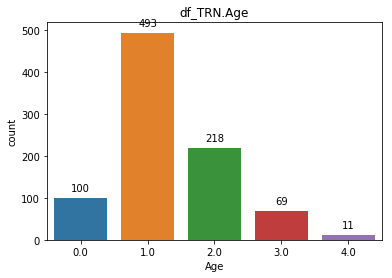

In [36]:
for i in [df_TRN,df_TST]:
    #  Age - ordinal values
    i.loc[i['Age'] <= 16, 'Age'] = 0
    i.loc[(i['Age'] > 16) & (i['Age'] <= 32), 'Age'] = 1
    i.loc[(i['Age'] > 32) & (i['Age'] <= 48), 'Age'] = 2
    i.loc[(i['Age'] > 48) & (i['Age'] <= 64), 'Age'] = 3
    i.loc[i['Age'] > 64, 'Age'] = 4

ax = sns.countplot(x=df_TRN.Age)
plt.title('df_TRN.Age')
for p in ax.patches:
   ax.annotate("%.0f" % p.get_height(),(p.get_x()+p.get_width()/2.,p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

[go to top of section](#engr2)

##  5.2  Create New Column - FareBand<a id="engr2_fare"></a>
Create a placeholder attribute called **FareBand** using **quantile cut (pd.qcut)** and update **Fare** with ordinal values from **FareBand**.

In [37]:
df_TRN['FareBand'] = pd.qcut(df_TRN['Fare'],4)
df_TST['FareBand'] = pd.qcut(df_TST['Fare'],4)
df_TRN[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


Update **Fare** with ordinal values from the **FareBand** table.

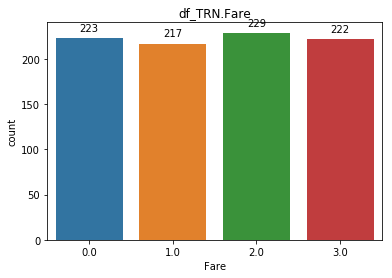

In [38]:
for i in [df_TRN,df_TST]:
    #  Fare - ordinal values
    i.loc[i['Fare'] <= 7.91, 'Fare'] = 0
    i.loc[(i['Fare'] > 7.91) & (i['Fare'] <= 14.454), 'Fare'] = 1
    i.loc[(i['Fare'] > 14.454) & (i['Fare'] <= 31), 'Fare'] = 2
    i.loc[i['Fare'] > 31, 'Fare'] = 3

ax = sns.countplot(x=df_TRN.Fare)
plt.title('df_TRN.Fare')
for p in ax.patches:
   ax.annotate("%.0f" % p.get_height(),(p.get_x()+p.get_width()/2.,p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

[go to top of section](#engr2)
##  5.3  Create New Column - AgeClass<a id="engr2_ageClass"></a>
Create attribute **AgeClass** by multiplying the ordinal values of **Age** and **Pclass**.

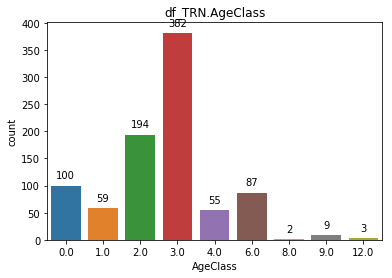

In [39]:
df_TRN['AgeClass'] = df_TRN['Age'] * df_TRN['Pclass']
df_TST['AgeClass'] = df_TST['Age'] * df_TST['Pclass']

ax = sns.countplot(x=df_TRN.AgeClass)
plt.title('df_TRN.AgeClass')
for p in ax.patches:
   ax.annotate("%.0f" % p.get_height(),(p.get_x()+p.get_width()/2.,p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

[go to top of section](#engr2)
##  5.4  Mapping - Sex, Embarked and Title<a id="engr2_map"></a>
Map values for Sex, Embarked and Title as:


|  attribute | mapping |
|:----|:----|
|Sex | male=0, female=1|
|Embarked | C = 0, Q = 1, S = 2|
|Title | Mr. = 0,Mrs. = 1,Master. = 2,Miss. = 3|

In [40]:
for i in [df_TRN,df_TST]:
    i['Sex'] = i['Sex'].map({'male':0, 'female':1})
    i['Embarked'] = i['Embarked'].map({'C':0,'Q':1,'S':2})
    i['Title'] = i['Title'].map({'Mr.':0,'Mrs.':1,'Master.':2,'Miss.':3})

df_TRN[['Sex','Embarked','Title']].head(5)

,Sex,Embarked,Title
0,0,2,0
1,1,0,1
2,1,2,3
3,1,2,1
4,0,2,0


[go to top of section](#engr2)
##  5.5  Drop Unneeded Columns<a id="engr2_drop"></a>
Following columns will not be used for machine learning and will be dropped from training and test datasets:

-  **AgeBand**:  Age is more informative than AgeBand
-  **AgeGroup**:  Age is more informative than AgeGroup
-  **Cabin**:  FarePerPerson is more informative than the location of the cabin
-  **FareBand**:  FarePerPerson is more informative than just the Fare amount
-  **Name**:  Titles already extracted, Name column no longer needed
-  **Parch**:  FamilySize created, Parch column no longer needed
-  **PassengerId**:  not needed for modeling, however, will be saved (*passID*) for the submission file
-  **SibSp**:  FamilySize created, SibSp column no longer needed
-  **Ticket**:  No information in this alphanumeric column

In [41]:
#  copy the PassengerId to another dataframe
#  will need it for submission
passID = df_TST.filter(['PassengerId'], axis=1)

drop_columns = ['AgeBand','AgeGroup','Cabin','FareBand','Name','Parch','PassengerId','SibSp','Ticket']

for i in drop_columns:
    df_TRN = df_TRN.drop(i, axis=1)
    df_TST = df_TST.drop(i, axis=1)

print(df_TRN.columns.values)
print(df_TST.columns.values)

['Survived' 'Pclass' 'Sex' 'Age' 'Fare' 'Embarked' 'Title' 'FamilySize'
 'IsAlone' 'FarePerPerson' 'AgeClass']
['Pclass' 'Sex' 'Age' 'Fare' 'Embarked' 'Title' 'FamilySize' 'IsAlone'
 'FarePerPerson' 'AgeClass']


[go to top of section](#engr2)
##  5.6  Change Datatypes to 'int64'<a id="engr2_int64"></a>
Verify that ordinal attribute datatypes to all integer.

In [42]:
#  change type to int
for i in ['Age','Fare','IsAlone','AgeClass']:
    df_TRN[i] = df_TRN[i].astype('int64')
    df_TST[i] = df_TST[i].astype('int64')

In [43]:
df_TRN.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,IsAlone,FarePerPerson,AgeClass
0,0,3,0,1,0,2,0,2,0,3.62500,3
1,1,1,1,2,3,0,1,2,0,35.64165,2
2,1,3,1,1,1,2,3,1,1,7.92500,3
3,1,1,1,2,3,2,1,2,0,26.55000,2
4,0,3,0,2,1,2,0,1,1,8.05000,6


[go to top of document](#top)     

---

#  6.  Feature Importance and Correlations<a id="corr"></a>
This section will encode and normalize the datasets, plot feature importance and show the overall, female and male correlations.

[6.1 Normalize Data ](#corr_norm)<br>
[6.2 Feature Importance](#corr_fi)<br>
[6.3 Correlation - Overall, Female and Male](#corr_corr)<br>

## 6.1  Normalize Data <a id="corr_norm"></a>
Normalization is a rescaling of the data from the original range so that all values are within a certain range, typically between 0 and 1.  Normalized data is essential in machine learning.  Correlation and models will not produce good results if the scales are not standardized.

In [44]:
from sklearn.preprocessing import MinMaxScaler

normTRN = MinMaxScaler().fit_transform(df_TRN)
normTST = MinMaxScaler().fit_transform(df_TST)

#  create dataframe with normalized data
df_TRN = pd.DataFrame(normTRN, index=df_TRN.index, columns=df_TRN.columns)
df_TST = pd.DataFrame(normTST, index=df_TST.index, columns=df_TST.columns)

#  move Survived columns to first position
col = df_TRN['Survived']
df_TRN.drop(labels=['Survived'], axis=1, inplace = True)
df_TRN.insert(0, 'Survived', col)
df_TRN.columns.values

df_TRN.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,IsAlone,FarePerPerson,AgeClass
0,0.0,1.0,0.0,0.25,0.000000,1.0,0.000000,0.1,0.0,0.007076,0.250000
1,1.0,0.0,1.0,0.50,1.000000,0.0,0.333333,0.1,0.0,0.069568,0.166667
2,1.0,1.0,1.0,0.25,0.333333,1.0,1.000000,0.0,1.0,0.015469,0.250000
3,1.0,0.0,1.0,0.50,1.000000,1.0,0.333333,0.1,0.0,0.051822,0.166667
4,0.0,1.0,0.0,0.50,0.333333,1.0,0.000000,0.0,1.0,0.015713,0.500000


[go to top of section](#corr)

##  6.2 Feature Importance <a id="corr_fi"></a>
Feature selection is the process of identifying the most significant features from a given dataset.

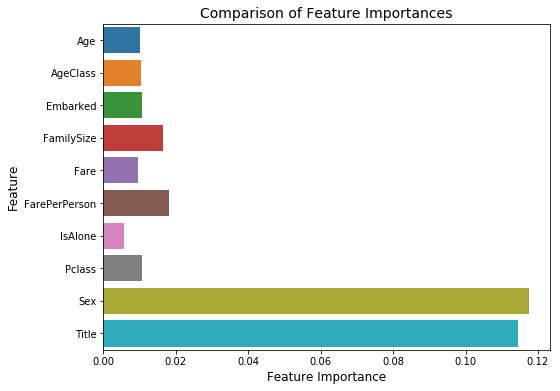

In [45]:
from sklearn.ensemble import ExtraTreesClassifier

y = df_TRN['Survived']
#  sort by column names
X = df_TRN.drop(['Survived'], axis=1).sort_index(axis=1)

# Building the model 
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5,criterion ='entropy', max_features = 5) 
# Training the model 
extra_tree_forest.fit(X, y) 
# Computing the importance of each feature 
feature_importance = extra_tree_forest.feature_importances_ 
# Normalizing the individual importances 
feature_importance_normalized = np.std([tree.feature_importances_ for tree in extra_tree_forest.estimators_], axis = 0) 

# Plot - compare feature importance
plt.figure(figsize=(8,6))
sns.barplot(x=feature_importance_normalized,y=X.columns)
plt.xlabel('Feature Importance',fontsize=12)
plt.ylabel('Feature',fontsize=12)
plt.title('Comparison of Feature Importances', fontsize=14)
plt.show()

We knew that **Sex** and **Title** would be significant factors in surviving the Titanic Disaster.  The correlation section will quantify the survival rates per attribute.

[go to top of section](#corr)

##  6.3 Correlation <a id="corr_corr"></a>
Correlation is a statistical test of association between variables that is measured on a -1 to 1 scale. The closer the correlation value is to -1 or 1 the stronger the association, the closer to 0, the weaker the association. It measures how change in one variable is associated with change in another variable. 

The following sub-sections will quantify the survival rates per attribute:

-  [OVERALL passengers](#corr_over)
-  [FEMALE passengers](#corr_female) - survival for female only
-  [MALE passengers](#corr_male) - survival for male only
-  [TABLE](#corr_table)

###  6.3.1 Correlation - OVERALL passengers<a id="corr_over"></a>

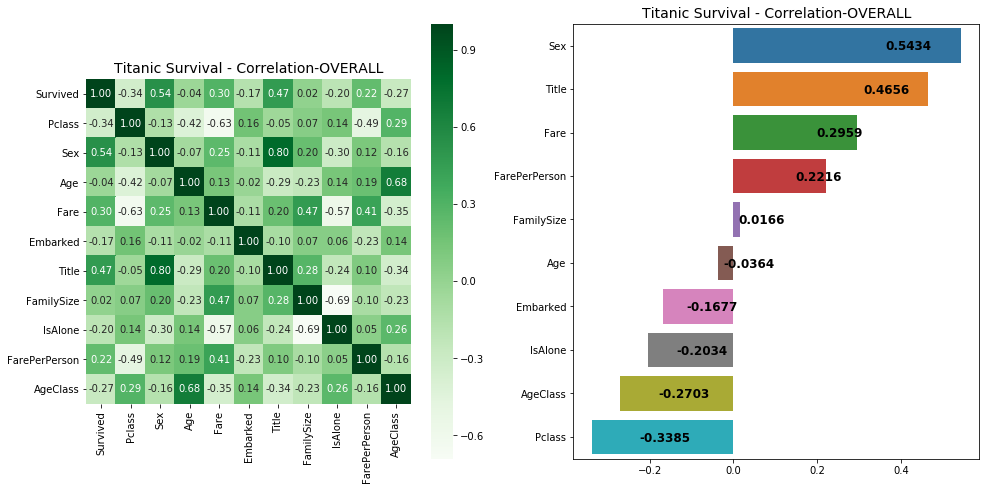

In [46]:
#  Correlation TABLE
corrALL = df_TRN.corr()['Survived'].sort_values(ascending=False)
corrALL = corrALL.drop(['Survived'])

#  heatmap and barplot
fig = plt.figure(figsize=(16,8))
fig.add_subplot(121)
plt.title('Titanic Survival - Correlation-OVERALL', fontsize=14)
sns.heatmap(df_TRN.corr(), annot=True, fmt='.2f', square=True, cmap = 'Greens')
fig.add_subplot(122)
plt.title('Titanic Survival - Correlation-OVERALL', fontsize=14)
ax = sns.barplot(y=corrALL.index,x=corrALL.values)
for i in ax.patches: 
    plt.text(i.get_width()/1.5, i.get_y()+.5,  
             str(round((i.get_width()), 4)), 
             fontsize = 12, fontweight ='bold', 
             color ='black')
plt.show()

[go to Correlation section](#corr_corr)
###  6.3.2 Correlation - FEMALE passengers<a id="corr_female"></a>

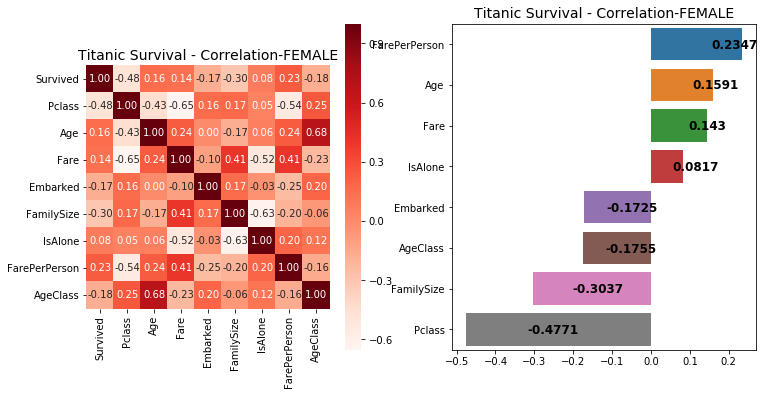

In [47]:
#  Correlation FEMALE - filter dataframe for female
dataFemale = df_TRN[(df_TRN['Sex'] == 1)]
dataFemaleCorr = dataFemale.drop(["Sex","Title"], axis=1).corr()
corrF = dataFemaleCorr['Survived'].sort_values(ascending=False)
corrF = corrF.drop(['Survived'])

#  heatmap and barplot
fig = plt.figure(figsize=(12,6))
fig.add_subplot(121)
plt.title('Titanic Survival - Correlation-FEMALE', fontsize=14)
sns.heatmap(dataFemaleCorr, annot=True, fmt='.2f', square=True, cmap = 'Reds')
fig.add_subplot(122)
plt.title('Titanic Survival - Correlation-FEMALE', fontsize=14)
ax = sns.barplot(y=corrF.index,x=corrF.values)
for i in ax.patches: 
    plt.text(i.get_width()/1.5, i.get_y()+.5,  
             str(round((i.get_width()), 4)), 
             fontsize = 12, fontweight ='bold', 
             color ='black')
plt.show()

[go to Correlation section](#corr_corr)
###  6.3.3 Correlation - MALE passengers<a id="corr_male"></a>

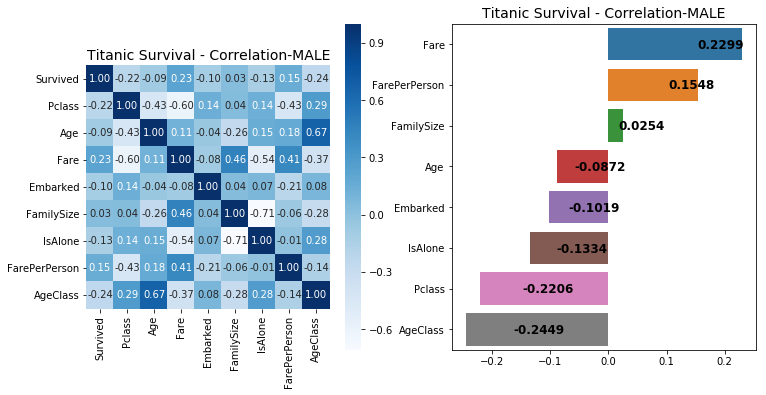

In [48]:
dataMale   = df_TRN[(df_TRN['Sex'] == 0)]
dataMaleCorr = dataMale.drop(["Sex","Title"], axis=1).corr()
corrM = dataMaleCorr['Survived'].sort_values(ascending=False)
corrM = corrM.drop(['Survived'])

#  heatmap and barplot
fig = plt.figure(figsize=(12,6))
fig.add_subplot(121)
plt.title('Titanic Survival - Correlation-MALE', fontsize=14)
sns.heatmap(dataMaleCorr, annot=True, fmt='.2f', square=True, cmap = 'Blues')
fig.add_subplot(122)
plt.title('Titanic Survival - Correlation-MALE', fontsize=14)
ax = sns.barplot(y=corrM.index,x=corrM.values)
for i in ax.patches: 
    plt.text(i.get_width()/1.5, i.get_y()+.5,  
             str(round((i.get_width()), 4)), 
             fontsize = 12, fontweight ='bold', 
             color ='black')
plt.show()

[go to Correlation section](#corr_corr)
###  6.3.4 Correlation Table<a id="corr_table"></a>

In [49]:
corrALL = pd.DataFrame(columns = ['MALE','correlation-m','FEMALE','correlation-f'])
corrALL['MALE']   = corrM.index
corrALL['correlation-m'] = corrM.values
corrALL['FEMALE'] = corrF.index
corrALL['correlation-f'] = corrF.values
corrALL

,MALE,correlation-m,FEMALE,correlation-f
0,Fare,0.229896,FarePerPerson,0.234720
1,FarePerPerson,0.154817,Age,0.159143
2,FamilySize,0.025361,Fare,0.142957
3,Age,-0.087181,IsAlone,0.081726
4,Embarked,-0.101877,Embarked,-0.172501
5,IsAlone,-0.133419,AgeClass,-0.175467
6,Pclass,-0.220618,FamilySize,-0.303717
7,AgeClass,-0.244913,Pclass,-0.477114


**OBSERVATIONS:**

**FarePerPerson** and **Embarked** were the most important factors for both male and female passengers.  This makes sense since most of the First Class passengers, paying the highest fare and boarding at Cherbourg, were kept informed of the disaster by the senior staff of the Titanic. They were given priority, along with women and children, to the lifeboats.

[go to top of document](#top)     

---
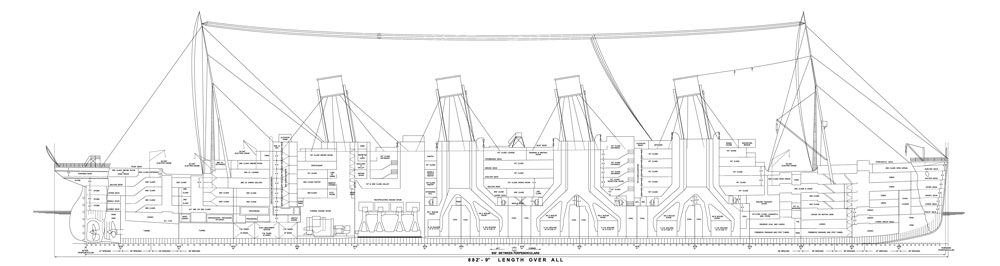

#  7. Machine Learning<a id="model"></a>
Machine Learning can be used to identify relationships and trends in data that might otherwise not be accessible or identified.  It gives computers the ability to learn without being explicitly programmed.  For the Titanic Disaster dataset, the training dataset will use supervised classification machine learning algorithms will be used to predict the survival outcomes of the passengers in the test dataset.

[7.1 Train/Test Split](#model_split)<br>
[7.2 Classification Models](#model_class)<br>
[7.3 Evaluate the Model](#model_eval)<br>

## 7.1 Train/Test Split <a id="model_split"></a>
Train/Test Split randomly splits a dataset into training and testing subsets.  The model learns on the training set based on known output, and the test data is used to evaluate the accuracy of the model.

In [50]:
from sklearn.model_selection import train_test_split

X = df_TRN.drop(['Survived'], axis = 1)
y = df_TRN['Survived']

seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

X_train.head()

Train set: (712, 10) (712,)
Test set: (179, 10) (179,)


,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,IsAlone,FarePerPerson,AgeClass
205,1.0,1.0,0.00,0.333333,1.0,1.0,0.1,0.0,0.010211,0.000000
718,1.0,0.0,0.25,0.666667,0.5,0.0,0.0,1.0,0.030254,0.250000
835,0.0,1.0,0.50,1.000000,0.0,1.0,0.2,0.0,0.054105,0.166667
851,1.0,0.0,1.00,0.000000,1.0,0.0,0.0,1.0,0.015176,1.000000
773,1.0,0.0,0.25,0.000000,0.0,0.0,0.0,1.0,0.014102,0.250000


[go to top of section](#model)

## 7.2 Classification Models <a id="model_class"></a>   
In machine learning, **classification** is a *supervised* learning approach which attempts to learn the relationship between a set of feature variables and a target variable. The target attribute in classification is a categorical variable with discrete values such as yes/no, start/go, on/off, survived/died.

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

#  Define the Classification Models
models = []
models.append(('DT   ', DecisionTreeClassifier()))
models.append(('KNN  ', KNeighborsClassifier()))
models.append(('LR   ', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('NB   ', GaussianNB()))
models.append(('RF   ', RandomForestClassifier()))
models.append(('SVC  ', SVC(gamma='auto')))
models.append(('lSVC ', LinearSVC()))

[go to top of section](#model)

## 7.3 Evaluate the Model<a id="model_eval"></a>
Evaluation allows the quality of the model to be assessed.  Following metrics will demonstrate the validity of the model prior to implementation with the test data.

[7.6.1 Cross Validation Score](#eval_cv)<br> 
[7.6.2 Accuracy Score](#eval_acc)<br> 
[7.6.3 F1 Score](#eval_f1)<br> 
[7.6.4 Confusion Matrix](#eval_conf)<br> 
[7.6.5 Receiver Operating Characteristics (ROC) Curve](#eval_roc)<br> 
[7.6.6 Classification Report](#eval_class)<br> 
[7.6.7 Log Loss](#eval_log)<br>

In [52]:
from sklearn import model_selection
from sklearn.metrics import accuracy_score

#  Evaluate the Models:
results = []
names = []
modelDF = pd.DataFrame(columns=['model','CV-mean','CV-std','AccuracyScore'])
countDF = 0

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    model.fit(X_train,y_train)
    modelPredict = model.predict(X_test)
    accu = accuracy_score(y_test,modelPredict)
    print("{0:s}:  {1:3.5f}  ({2:3.5f})  {3:.2%}".format(name,cv_results.mean(),cv_results.std(),accu))
    modelDF.loc[countDF]=[name,cv_results.mean(),cv_results.std(),accu]
    countDF = countDF + 1

DT   :  0.82590  (0.06127)  78.77%
KNN  :  0.82314  (0.03608)  79.89%
LR   :  0.81185  (0.04642)  74.86%
NB   :  0.79920  (0.04296)  74.30%
RF   :  0.82029  (0.05307)  77.65%
SVC  :  0.80205  (0.04328)  72.63%
lSVC :  0.80765  (0.04885)  75.98%


**Picking the algorithm with the best Cross Validation Score.**

In [53]:
#  pick the best model from ModelDF
max(modelDF['CV-mean'])
maxCV = modelDF[(modelDF['CV-mean'] == max(modelDF['CV-mean']))]
maxCV

,model,CV-mean,CV-std,AccuracyScore
0,DT,0.8259,0.061266,0.787709


In [54]:
#best_model = SVC(gamma='auto')
best_model = KNeighborsClassifier()
best_model.fit(X_train,y_train)
print(best_model)

#  predict
y_predict = best_model.predict(X_test)
y_predict[0:10]

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


array([0., 0., 0., 0., 1., 1., 0., 0., 0., 1.])

[back to "Evaluate the Model"](#model_eval)
### 7.6.1 Cross Validation Score<a id="eval_cv"></a>   
**Cross Validation Score** splits the dataset into K equal groups. Each group is referred to as a fold.  Some of the folds are used for training and the remaining for testing the model.  The process is repeated until each partition is used for both training and testing.

In [55]:
from sklearn.model_selection import cross_val_score

cross_val = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross Validation Scores:         {}".format(cross_val))
print('Cross Validation Scores - mean:  {:3.4%}'.format(cross_val.mean()))

Cross Validation Scores:         [0.76223776 0.81818182 0.81818182 0.84507042 0.78723404]
Cross Validation Scores - mean:  80.6181%


[back to "Evaluate the Model"](#model_eval)
### 7.6.2 Accuracy Score<a id="eval_acc"></a>   
**Accuracy Score** function computes subset accuracy in a multilabel classification dataset and is equal to the **Jaccard Score** function in binary and multiclass classification.

In [56]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_predict)
print('Accuracy Score:  {:3.4%}'.format(accuracy_score(y_test,y_predict)))

Accuracy Score:  79.8883%


[back to "Evaluate the Model"](#model_eval)
### 7.6.3 F1 Score<a id="eval_f1"></a>   
**F1 Score** is the weighted average of Precision and Recall.

In [57]:
from sklearn.metrics import f1_score

f1score = f1_score(y_test, y_predict)
print('F1 Score:  {:3.4%}'.format(f1score))

F1 Score:  72.3077%


[back to "Evaluate the Model"](#model_eval)
### 7.6.4 Confusion Matrix<a id="eval_conf"></a>   
Confusion matrix shows the corrected and wrong predictions, in comparison with the actual labels. It shows the model’s ability to correctly predict or separate the classes.

   - **True Positive [0,0]** – model predicted positive class correctly to be a positive class
   - **False Positive [0,1]** – model predicted negative class incorrectly to be a positive class
   - **False Negative [1,0]** – model predicted positive class incorrectly to be the negative class
   - **True Negative [1,1]** – model predicted negative class correctly to be the negative class

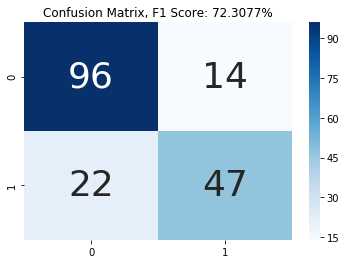

In [58]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_predict)

sns.heatmap(conf_matrix, annot=True,cmap='Blues',annot_kws={"size": 36})
plt.title("Confusion Matrix, F1 Score: {:3.4%}".format(f1score))
plt.show()

[back to "Evaluate the Model"](#model_eval)
### 7.6.4 Receiver Operating Characteristics (ROC) Curve<a id="eval_roc"></a>   
AUC–ROC curve is the model selection probability curve. AUC area is covered by the curve is the area between the orange line (ROC) and the axis.  The bigger the area covered, the better the machine learning models. Ideal value for AUC is 1.

*  **ROC** - Receiver Operating Characteristics
*  **AUC** - Area Under the Curve

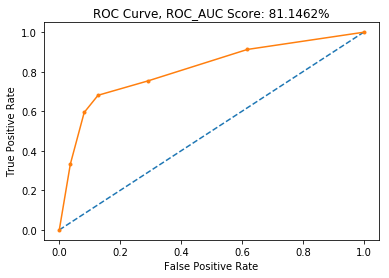

In [59]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

best_model.probability = True   # need for predict_proba to work
best_model.fit(X_train,y_train)
y_predita = best_model.predict_proba(X_test)
y_predita = y_predita[:,1]   # positive values only

ROC_AUC = roc_auc_score(y_test, y_predita)
fpr, tpr, thresholds = roc_curve(y_test, y_predita)

plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title("ROC Curve, ROC_AUC Score: {:3.4%}".format(ROC_AUC))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

[back to "Evaluate the Model"](#model_eval)
### 7.6.5 Classification Report<a id="eval_class"></a>   
**Precision** is a measure of the accuracy, provided that a class label has been predicted. It is defined by:   
*  ```precision = True Positive/(True Positive + False Positive)```   
    
**Recall** is the true positive rate:    
*  ```recall = True Positive/(True Positive + False Negative)```   
    
**F1-Score** is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (which represents perfect precision and recall) and its worst at 0    
*  ```F1-Score = 2x (precision x recall)/ (precision + recall)```

In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84       110
         1.0       0.77      0.68      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



[back to "Evaluate the Model"](#model_eval)
### 7.6.5 Log Loss<a id="eval_log"></a> 
Logarithmic loss measures the performance of a classification model where the prediction input is a probability value between 0 and 1. The goal of machine learning models is to minimize this value. A perfect model would have a log loss of 0.

In [61]:
from sklearn.metrics import log_loss

y_predict_prob = best_model.predict_proba(X_test)
print(y_predict_prob[0:5])

print("\nLog Loss:  {:3.4}".format(log_loss(y_test, y_predict_prob)))

[[0.8 0.2]
 [0.8 0.2]
 [0.6 0.4]
 [0.8 0.2]
 [0.  1. ]]

Log Loss:  2.26


[go to top of document](#top)     

---
#  8. Submission File<a id="sub_file"></a>
Using model with the best Cross Validation score to run the predictions and submit the file.

In [62]:
# Check shape of TEST data
print('Test data shapes must match order to \"fit\":')
print('shape X_test:\t{}'.format(X_test.shape))
print('shape y_test:\t{}'.format(y_test.shape))
print('shape df_TST:\t{}'.format(df_TST.shape))

Test data shapes must match order to "fit":
shape X_test:	(179, 10)
shape y_test:	(179,)
shape df_TST:	(418, 10)


---
<b>CAUTION:</b> Make sure that 'PassengerId' and 'Survived' are saved as **int64** in the submission file.  Otherwise, the submission will be accepted, but scored as '0.000'.

---

In [63]:
print(best_model)
best_model.fit(X_test,y_test)          #  fit
SF = best_model.predict(df_TST)        #  predictions

#  Add PassengerId back into test data
df_TST['PassengerId'] = passID['PassengerId']

SF = pd.DataFrame(SF, columns=['Survived'])
SF_TST = pd.concat([df_TST, SF], axis=1, join='inner')
SF_final = SF_TST[['PassengerId','Survived']].astype("int64")

#  SF_final.to_csv('<path>/predictions.csv', index=False)
print('all done ...')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
all done ...


[go to top of document](#top)     

---

# END

Please upvote if you found this useful :-)

---
***PS:  There was room for Jack!***